In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network

from imblearn.keras import balanced_batch_generator

from sklearn.metrics import classification_report, confusion_matrix,balanced_accuracy_score
import math
import csv
from PIL import Image
from PIL import Image, ImageEnhance 
import glob
%matplotlib inline

Using TensorFlow backend.


In [2]:
# total_images_train = os.listdir('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/')
print(os.listdir('../input/'))
image_height = 200#250
image_width = 400#250


['bio-1model-w-validation-output', 'chest-xray-pneumonia']


In [3]:
# model1.load_weights('../input/***.hdf5'))

model = load_model('../input/bio-1model-w-validation-output/best_weights.hdf5')

In [4]:
def flat_list(csvfile):
    listoflists = csvfile.values.tolist()
    return([item for sublist in listoflists for item in sublist])

test_paths = flat_list(pd.read_csv("../input/bio-1model-w-validation-output/test_paths.csv"))
test_labels = flat_list(pd.read_csv("../input/bio-1model-w-validation-output/test_labels.csv"))

# train_paths = flat_list(pd.read_csv("../input/bio-1model-w-validation-output/train_paths.csv"))
# train_labels = flat_list(pd.read_csv("../input/bio-1model-w-validation-output/train_labels.csv"))
# val_paths = flat_list(pd.read_csv("../input/bio-1model-w-validation-output/val_paths.csv"))
# val_labels = flat_list(pd.read_csv("../input/bio-1model-w-validation-output/val_labels.csv"))

In [5]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)



def img_prepro(imgpath, editreport = False):
    oimg = cv2.imread(imgpath)
    edits = []

    #Crop
    x,y=oimg.shape[0:2]
    if y>x: 
        start, end = (y-x)//2, y - (y-x)//2
        crimg = oimg[:,start:end,:]
        edits.append(('crop',0,start)) # ('crop',dx,dy)

    else:  
        start, end = (x-y)//2, x - (x-y)//2
        crimg = oimg[start:end,:,:]
        edits.append(('crop',start,0))

    #Crop
    c0,c1 = crimg.shape[0:2]
    x0,x1 = int(c0*(0.5-0.3)), int(c0*(0.5+0.3)) # ypsos
    y0,y1 = 0,c1
    vis = crimg[x0:x1,y0:y1,:]
    edits.append(('crop',x0,y0)) # ('crop',dx,dy)

    # plt.imshow(vis)

    # Resize
    prev_height, prev_width = vis.shape[0:2]
    img2 = cv2.resize(vis, (image_width, image_height))
    edits.append(('resize', image_width, image_height, prev_width, prev_height))

#     plt.imshow(img2)

    if editreport == True: return(edits) 
    else:
        # Contrast
        temp = Image.fromarray(img2)
        res = change_contrast(temp, 100)
        res = np.array(res)
        img = res.astype(np.float32)/255
        return img

In [6]:
def Conf_Matrix(test_labels, predicted_labels):
    print('Confusion Matrix : \n')
    cm = confusion_matrix(test_labels, predicted_labels,labels = [1,0])
    fig, ax = plt.subplots()
    fig.set_size_inches(9,9)
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    ax.set_ylabel('Actual label');
    ax.set_xlabel('Predicted label');
    target_names = ['Virus','Bacteria']
    ax.set_xticklabels(target_names)
    ax.set_yticklabels(target_names)
    accuracy = np.sum(test_labels == predicted_labels.T)/len(predicted_labels)
    ax.set_title('Accuracy Score: {}'.format(accuracy))
    fig.show()
    

In [7]:
# Load Data
test_files = []
for file in test_paths:
    test_files.append(img_prepro(imgpath=file, editreport = False))
    
test_files = np.array(test_files)


test_files = []
for file in test_paths:
    test_files.append(img_prepro(imgpath=file, editreport = False))
test_files = np.array(test_files)

pred_class = model.predict_classes(test_files)
pred_prob = model.predict(test_files)


Confusion Matrix : 



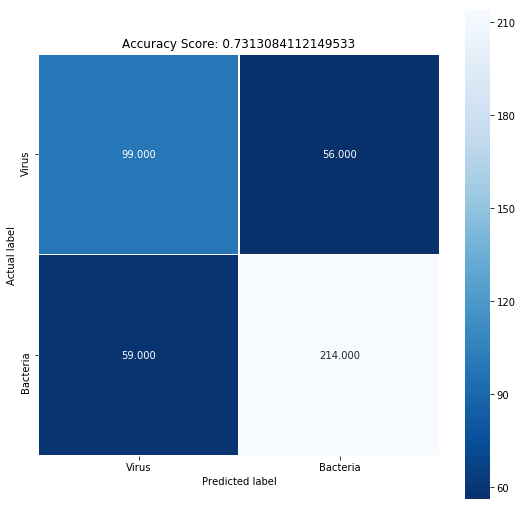

In [8]:
Conf_Matrix(test_labels, pred_class)

In [9]:
print('Balanced Acc:')
print(balanced_accuracy_score(test_labels, pred_class))


Balanced Acc:
0.7112962306510693


In [10]:
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score  

def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC: 0.75


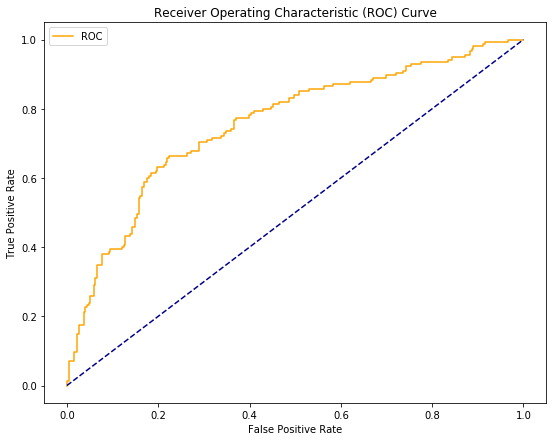

In [11]:
auc = roc_auc_score(test_labels, pred_prob)  
print('AUC: %.2f' % auc)  

fpr, tpr, thresholds = roc_curve(test_labels, pred_prob)  
plt.figure(figsize=(9,7))
plt.grid(False)
plot_roc_curve(fpr, tpr)  

#  Visualizations

In [12]:
# https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras
import PIL, copy
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)


In [13]:
def display_activation_mine(activations, act_index): 
    filters = model.layers[act_index].get_config()['filters']
    layername = model.layers[act_index].get_config()['name']
    activation = activations[act_index]
    activation_index=0
    col_size = 4
    row_size = int(np.ceil(filters/col_size))
#     fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    fig, ax = plt.subplots(row_size, col_size)#, figsize=(15,15))
    fig.set_figheight(25*(filters//32))
    fig.set_figwidth(20)
#     print('Displaying activation (output) of layer', act_index)#-1)
    print('Displaying activation (output) of layer', act_index,'(',layername,')','and total filters =',filters)
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis')#'gray')
            activation_index += 1
            
def display_one_activation(activations, act_index, activation_index=0): 
    activation = activations[act_index]
    fig, ax = plt.subplots(1, 1)
    print('Displaying activation (output) of layer', act_index-1,'and filter No:',activation_index)
    plt.imshow(activation[0, :, :, activation_index], cmap='viridis')
    
# def return_one_activation(activations, layer, filt=0): 
#     activation = activations[layer]
#     fig, ax = plt.subplots(1, 1)
# #     print('Displaying activation (output) of layer', layer-1,'and filter No:',activation_index)
#     return(activation[0, :, :, filt])
    
    
    
def avgPixelValueofLayer(activations, layer):
    activation = activations[layer]
    filters = model.layers[layer].get_config()['filters']
    print('Getting activations (output) of layer', layer, 'with total # of filters =', filters)
    avgpixelvalue = dict()
    for filt in range(filters):
        img = activation[0, :, :, filt]
        c,sumi=0,0
        for i in img.flatten():
            c+=1
            sumi+=i
        res = sumi/c # activ per pixel
        avgpixelvalue[filt] = res
    return avgpixelvalue
        
    
def getTopNFilters(activations, layer=0, N=0): # N = 0 for all filters
    PixelValue = avgPixelValueofLayer(activations, layer)
    sortedPV = sorted(PixelValue.items(), key=lambda kv: kv[1], reverse = True)
    maxfilters = []
    if N == 0: window = sortedPV
    else: window = sortedPV[0:N]
    for tup in window:
        maxfilters.append(tup[0])
    return maxfilters

    
    
# Keep the important  pixels only
def importantPixels(img): # img = 2D not 3D! -> img.shape = (x,y), not (x,y,3)!!! 
    rows, columns = img.shape
    minp, maxp, sump = 1000, 0, 0
    for row in range(rows):
        for col in range(columns):
            pixel = img[row][col]
            sump += pixel
            if pixel > maxp: maxp = pixel
            if pixel < minp: minp = pixel

    avgp =  sump/(rows*columns)           

#     print(minp,maxp,avgp)

    threshold = max(maxp * 0.8, avgp*1.01)
    for row in range(rows):
        for col in range(columns):
            if img[row][col] <threshold: img[row][col] = 0
            else: img[row][col] = 1
    return img    
    
    
# find important rectangles
def Rectangles(img):
    importimg = importantPixels(img)
    im = np.array(importimg * 255, dtype = np.uint8)
    ret, thresh = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
    
    return(n_labels, labels, stats, centroids, im)




def plotRectangles(img,flag = 1):
    importimg = importantPixels(img)
    im = np.array(importimg * 255, dtype = np.uint8)
    ret, thresh = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)

    # plot 
    size_thresh = 10000000
    for i in range(1, n_labels):
    #     i=10
        if stats[i, cv2.CC_STAT_AREA] <= size_thresh:
            #print(stats[i, cv2.CC_STAT_AREA])
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            cv2.rectangle(im, (x, y), (x+w, y+h), (255, 255, 255), thickness=10) # ANAPODA?????????!?!?!?!?!?!?!?!?!?
#             cv2.rectangle(im, (y, x), (y+w,x+h), (255, 255, 255), thickness=5) 
#         print(n_labels,stats)
        if flag:
            plt.imshow(im,cmap='gray')
        else:
            return(im)
        
        
        
# Map Rectangles or just Pixels to Original Image from Output Image
def MapRectAndPixels2OrigImg(edits,x,y,w=0,h=0,rect=True, contour = False):

    for edit in edits[::-1]:    # iterate backwards
        if edit[0] == 'crop':
            if contour == True:
                dx, dy = edit[1], edit[2]
                x_prev = x + dy # !!!!! x <-> y einai anapoda sta shmeia kai sta rectangles !!!!!
                y_prev = y + dx
            else: 
                dx, dy = edit[1], edit[2]
                x_prev = x + dx
                y_prev = y + dy
                w_prev, h_prev = w, h

        elif edit[0] == 'resize':
            if contour == True:
                x_prev = x * edit[3]/edit[1]
                y_prev = y * edit[4]/edit[2]
            else:
                res_width, res_height, prev_width, prev_height = edit[1], edit[2], edit[3], edit[4]
                x_prev = x * prev_height/res_height
                y_prev = y * prev_width/res_width        
                h_prev = h * prev_height/res_height
                w_prev = w * prev_width/res_width
            
        
#         print('xprev:', x_prev,'yprev:', y_prev,'x:',x,'y:',y) 
        x, y= int(x_prev), int(y_prev)
        if contour == False: w, h = int(w_prev), int(h_prev)
    if rect:return (x, y, w, h) # rectagle
    else: return(x,y) # just a pixel        

    
# Let's corespond mark rectangles to original image

# imgpath = train_files_paths[0]
# prepro_img = train_files[0]
def matchRect2OriginalImg(imgpath, prepro_img, layer, topfilters = 1):
    activations = activation_model.predict(prepro_img.reshape(1,image_height,image_width,3))
    filters = getTopNFilters(activations, layer=layer, N=topfilters)
    print('Top Filters:', filters)
    activation = activations[layer]
    oimg = cv2.imread(imgpath)
    oimgcp = oimg.copy()
    
    temp = np.array(prepro_img * 255, dtype = np.uint8)
    forplot = [oimgcp,temp]
    plotlabels = []
    for filt in filters:
        filtIMG = activation[0, :, :, filt]
        forplot.append(np.array(filtIMG * 255, dtype = np.uint8))
        n_labels, labels, stats, centroids, im = Rectangles(filtIMG)
        edits = img_prepro(imgpath, editreport = True)
        
        # account for resizes after all the layers
        hei, wid = im.shape
        temp = edits[-1]
        if temp[0]== 'resize':
            prev_width, prev_height = temp[1], temp[2]
            edits.append(('resize', wid, hei, prev_width, prev_height))
        else: print('Error: Last user edit was not Resize and we dont know the image shape!')
        
        
        forplot.append(im)
        plotRectangles(filtIMG) # ginetai plot
#         forplot.append(plotRectangles(filtIMG)) # auto deixnei mono to 1o label... :(
        plotlabels.append(labels)

        for i in range(1, n_labels):
        # i = 1
            y = stats[i, cv2.CC_STAT_LEFT] # or x???
            x = stats[i, cv2.CC_STAT_TOP] # or y???
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]
            
            x, y, w, h = MapRectAndPixels2OrigImg(edits,x,y,w,h,rect=True)
        
#             im1 = np.array(oimg, dtype = np.uint8)
#             gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)     
            ### cv2.rectangle(gray, (x, y), (x+h, y+w), (255, 255, 255), thickness=10)  
            cv2.rectangle(oimg, (y, x), (y+w,x+h), (255, 0, 0), thickness=10)  

#     plt.imshow(oimg,cmap='gray')
    forplot.append(oimg)
    return(forplot,plotlabels,edits)    
    
# Superimpose activation Regions (Labels) to Original Image
def MapLabels2OrigImg(img_path, plotlabels):
    oimg = cv2.imread(img_path)
    window = oimg.copy()
    out = oimg.copy()
    out2 = oimg.copy()

    for img in plotlabels:        
        height,width = img.shape     
        
        edits = img_prepro(img_path, editreport = True)    
        # account for resizes after all the layers
        temp = edits[-1]
        if temp[0]== 'resize':
            prev_width, prev_height = temp[1], temp[2]
            edits.append(('resize', width, height, prev_width, prev_height))
        else: print('Error: Last user edit was not Resize and we dont know the image shape!')

            
        for i in range(height):
            for j in range(width):                
                x, y, w, h = MapRectAndPixels2OrigImg(edits,i,j,w=1,h=1,rect=True) # i,j = coordinates of output (filter) image
                pt = 0 # pixel_thickness
                
                startx, endx, starty, endy = x-int(h), x+int(h), y-int(w), y+int(w)
                
                out[startx-pt : endx+pt, starty-pt : endy+pt, 0] = int(img[i,j]*255)
                out2[startx-pt : endx+pt, starty-pt : endy+pt, 0] += int(img[i,j]*255)
                window[startx:endx, starty:endy, 0] =255
     
    x,y = oimg.shape[0:2]
    for i in range(x):
        for j in range(y):
            if out[i,j,0]>255: out[i,j,0]=255
            if out2[i,j,0]>255: out2[i,j,0]=255
        
#     out[:,2:50,0] = 255
#     out[:,2:50,1] = 0
#     out[:,2:50,2] = 0
    return([oimg,window,out,out2])
    


In [14]:
prepro_img = test_files[0]
img_path = test_paths[0]
# layer = 9
layer = 8
topNfilters = 1
# activations = activation_model.predict(prepro_img.reshape(1,image_height,image_width,3))

Getting activations (output) of layer 8 with total # of filters = 128
Top Filters: [90]


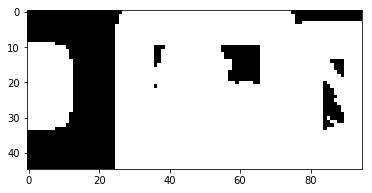

In [15]:
forplot,plotlabels,edits  = matchRect2OriginalImg(img_path, prepro_img, layer=layer, topfilters = topNfilters)

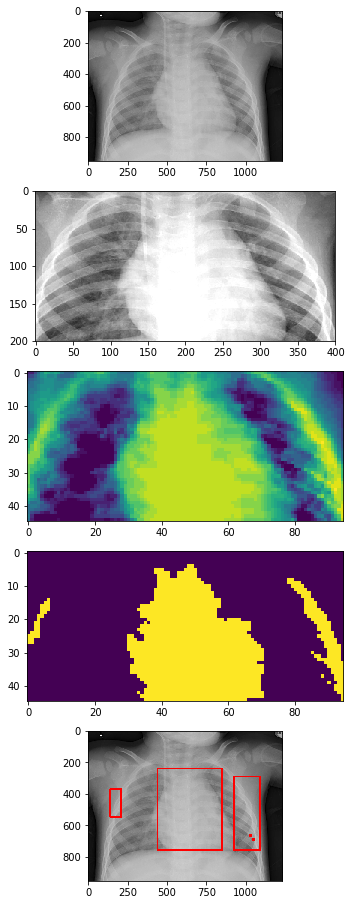

In [16]:
figs = len(forplot)
fig, ax = plt.subplots(figs, figsize=(10,20*figs//6))
c=0
for image in forplot:
    ax[c].imshow(image)
    c+=1
    

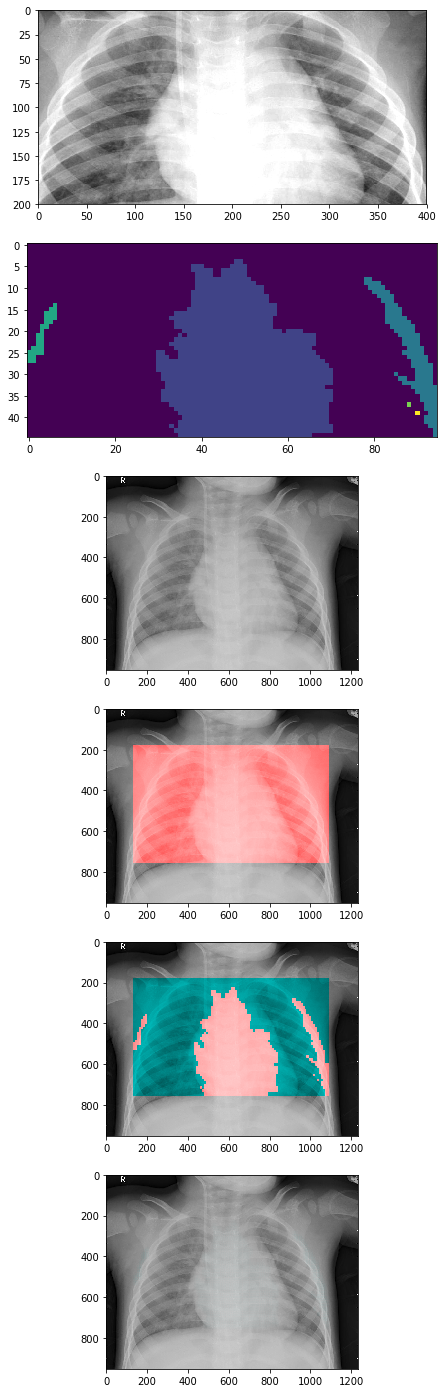

In [17]:
figslist = [prepro_img] + plotlabels

figslist += MapLabels2OrigImg(img_path, plotlabels)

figs = len(figslist)
fig, ax = plt.subplots(figs, figsize=(10,25*figs//6))
c=0
for image in figslist:
    ax[c].imshow(image)
    c+=1

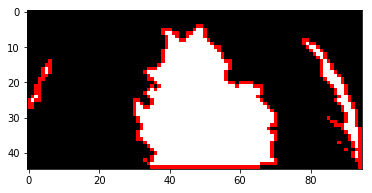

In [18]:
img = plotlabels[0].copy()
x,y = img.shape

for i in range(x):
    for j in range(y):
        if img[i,j]>0:
            img[i,j] = 255
img8 = img.astype(np.uint8)

ret, thresh = cv2.threshold(img8, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img3d = np.zeros([x,y,3])
img3d[:,:,0] = img
img3d[:,:,1] =  img 
img3d[:,:,2] =  img

cv2.drawContours(img3d, contours, -1, (255, 0, 0), 1)
plt.imshow(img3d)
# plt.axis("off");


In [19]:
img3d.shape

(45, 95, 3)

In [20]:
# plt.imshow(img,cmap='gray')

In [21]:

new_contours = copy.deepcopy(contours)

In [22]:
img = cv2.imread(img_path)       
f=0
for cont in range(len(new_contours)):
    for point in range(len(new_contours[cont])):
        for i in range(len(new_contours[cont][point])):
            xy = new_contours[cont][point][i]
            x,y = xy[0], xy[1]
            new_coord = MapRectAndPixels2OrigImg(edits,x,y,rect=False,contour = True)
            newx,newy = new_coord[0], new_coord[1]

            new_contours[cont][point][i][0]= newx
            new_contours[cont][point][i][1]= newy
            if f ==0:
                print(edits)
                print(x,y,newx,newy)
                f=1
        

[('crop', 0, 140), ('crop', 190, 0), ('resize', 400, 200, 952, 571), ('resize', 95, 45, 400, 200)]
90 39 1039 683


In [23]:
MapRectAndPixels2OrigImg(edits,90,39,rect=False)

(1332, 530)

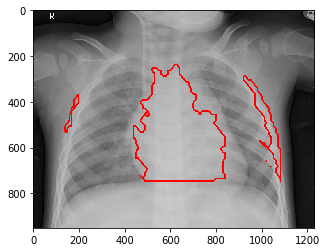

In [24]:
im = cv2.imread(img_path)
cv2.drawContours(im, new_contours, -1, (255, 0, 0), 5)
plt.imshow(im)


In [25]:
edits

[('crop', 0, 140),
 ('crop', 190, 0),
 ('resize', 400, 200, 952, 571),
 ('resize', 95, 45, 400, 200)]

In [26]:
# model.summary()

Displaying activation (output) of layer 8 ( conv2d_5 ) and total filters = 128


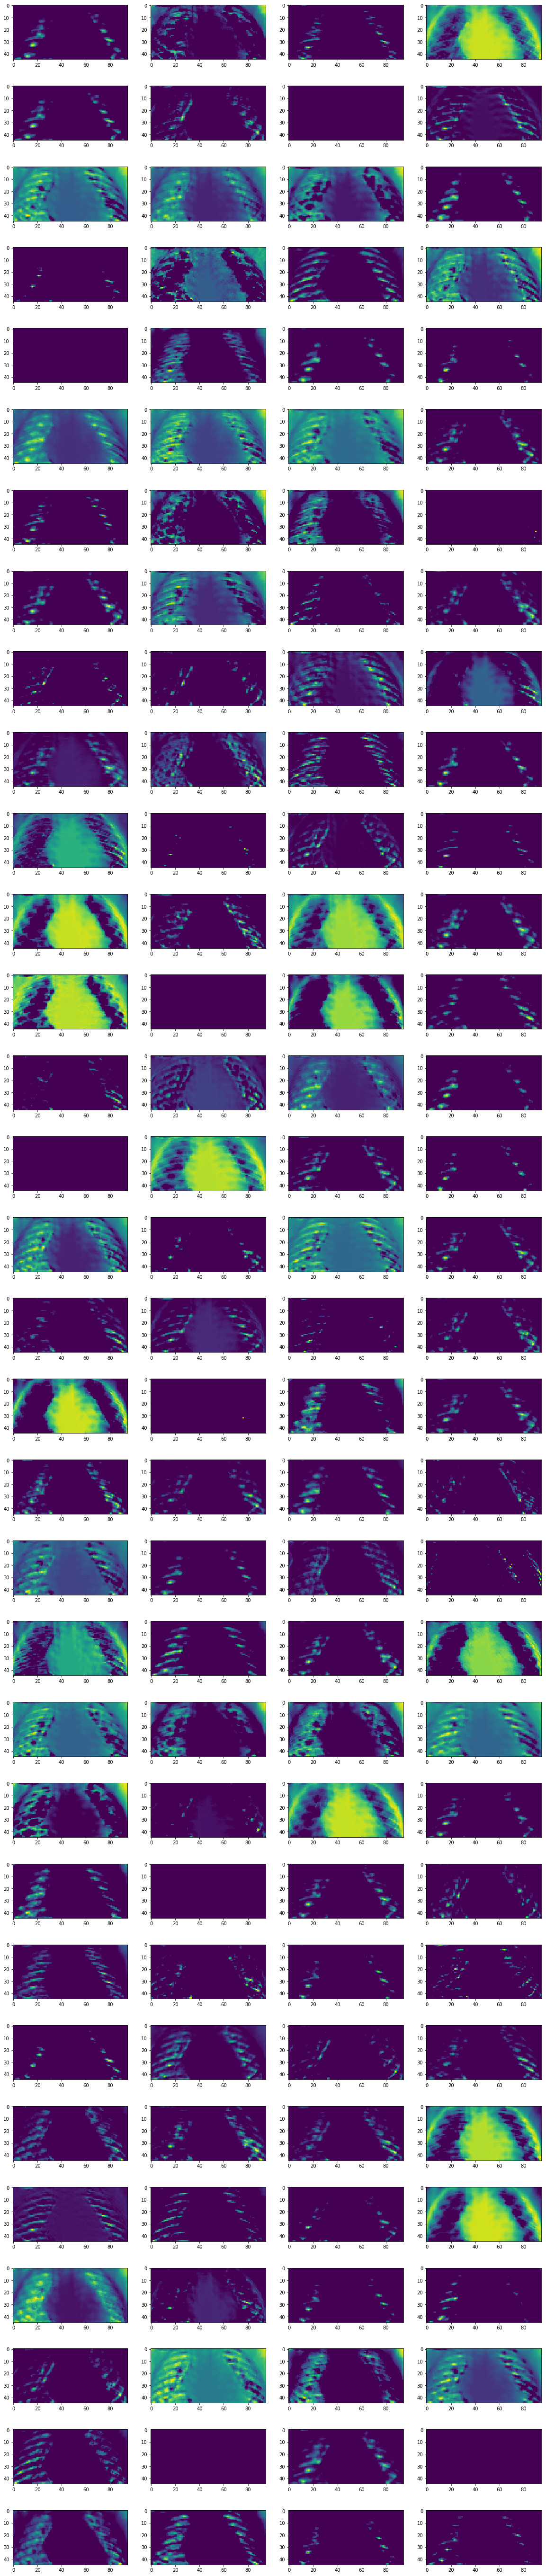

In [27]:
# layer = previously defined

activations = activation_model.predict(prepro_img.reshape(1,image_height,image_width,3))
display_activation_mine(activations, layer)